In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms.functional as tvF

In [2]:
import matplotlib
#matplotlib.use('Inline')
import matplotlib.pyplot as plt
from tqdm import tqdm

## Prepare Data
* download data, prepare DataLoader
* prepocess:
    1. Color transform. (RGB to YUV; for mnist Grey to RGB to YUV)
        * for mnist, no preprocessing, since it is in gray value
        * for Cifar-10, RGB and scale to [0.0, 1.0]. No abs
        
    2. RandomResizedCrop(size=24) for Cifar-10

In [3]:
def save_model(name, model):
    print("Saving models...")
    model.eval()

    save_model_filename = 'saved_models/' + name + '.pt'

    torch.save(model.state_dict(), save_model_filename)
    
def load_model(name, model):
    model.load_state_dict(torch.load('saved_models/' + name + '.pt'))
    
def test_acc(dataloader ,model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels =  data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


In [4]:
BATCH_SIZE  = 128

EPOCH = 30

use_cuda = torch.cuda.is_available()

torch.manual_seed(1024)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
# # MNIST
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('./data', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,)),
#                        # the Abs was done here
#                        transforms.Lambda(lambda x: x.abs()),
#                    ])),
#     batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('./data', train=False, 
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,)),
#                        transforms.Lambda(lambda x: x.abs()),
#                    ])),
#     batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [6]:
class Identity(): # used for skipping transforms
    def __call__(self, im):
        return im
    
def transform_cifar(is_train):
    
    return transforms.Compose([
                                transforms.RandomCrop(size=24) if is_train else Identity(),
                                transforms.RandomHorizontalFlip(p=0.5) if is_train else Identity(),
                                transforms.CenterCrop(size=24) if not is_train else Identity(),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                #transforms.Lambda(lambda x: x.abs()),
                            ])

class ConvLayer(torch.nn.Module):
    """
        out = ((in+2*padding-(kernel_size-1)-1)/stride)+1
        
        when kernel_size is: odd number, the output is only affected by stride
                             even number, use the formula.
        
        For example: if kernel size is odd, and with stride 1 then out = in, but
        channel changes. With stride 2, out is halved.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [7]:
# Cifar-10

is_train = True

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_cifar(is_train))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

is_train = False

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_cifar(is_train))

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
data, label = next(iter(trainloader))

In [9]:
torch.max(data[:10])

tensor(1.)

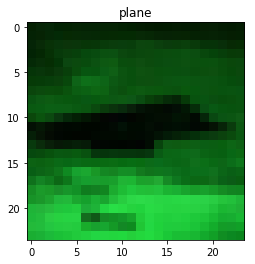

In [10]:
idx = 100
plt.imshow(data[idx].permute(1,2,0))
plt.title(classes[label[idx]])
plt.show()

In [11]:
class Raw_CNN(nn.Module):
    def __init__(self):
        super(Raw_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, 1, bias=True)
        self.conv2 = nn.Conv2d(64, 64, 5, 1, bias=True)
        self.conv3 = nn.Conv2d(64, 64, 3, 1, bias=True)
        self.fc1 = nn.Linear(64 * 3 * 3, 64, bias=True)
        self.fc2 = nn.Linear(64, 10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #(3, 24, 24) -> (64, 20, 20)
        x = F.max_pool2d(x, 2, 2) #(64, 10, 10)
        x = F.relu(self.conv2(x)) #(64, 6, 6)
        x = F.max_pool2d(x, 2, 2) #(64, 3, 3)
        x = x.view(-1, 64 * 3 * 3)    #(64*3*3)
        x = F.relu(self.fc1(x))   #(64*1*1)
        x = self.fc2(x)           #(10*1*1)
        return F.log_softmax(x, dim=1)

class Tailored_CNN(nn.Module):
    def __init__(self):
        super(Tailored_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64, 5, 1, bias=False)
        self.conv3 = nn.Conv2d(64, 64, 3, 1, bias=False)
        self.fc1 = nn.Linear(64 * 3 * 3, 64, bias=False)
        self.fc2 = nn.Linear(64, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #(3, 24, 24) -> (64, 20, 20)
        x = F.avg_pool2d(x, 2, 2) #(64, 10, 10)
        x = F.relu(self.conv2(x)) #(64, 6, 6)
        x = F.avg_pool2d(x, 2, 2) #(64, 3, 3)
        x = x.view(-1, 64 * 3 * 3)    #(64*3*3)
        x = F.relu(self.fc1(x))   #(64*1*1)
        x = self.fc2(x)           #(10*1*1)
        return F.log_softmax(x, dim=1)

In [12]:
raw_cnn = Raw_CNN().to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(raw_cnn.parameters(), lr=0.001)

for epoch in tqdm(range(EPOCH)):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        print(inputs.shape)
        print(labels.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = raw_cnn(inputs)
        
        print('outputs.shape', outputs.shape)
        print('labels.shape',labels.shape)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

save_model('raw_cnn', raw_cnn)

  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
label

torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
label

torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
label

torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
label

torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
label

  3%|▎         | 1/30 [00:04<02:08,  4.45s/it]

torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
label

torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])
torch.Size([128, 3, 24, 24])
torch.Size([128])
outputs.shape torch.Size([128, 10])
labels.shape torch.Size([128])


KeyboardInterrupt: 

In [14]:
test_acc(testloader, raw_cnn)

Accuracy of the network on the 10000 test images: 67 %


In [15]:
tailored_cnn = Tailored_CNN().to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tailored_cnn.parameters(), lr=0.001)

for epoch in tqdm(range(EPOCH)):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = tailored_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

save_model('tailor_cnn', tailored_cnn)


100%|██████████| 30/30 [01:58<00:00,  3.94s/it]


Finished Training
Saving models...


In [17]:
test_acc(testloader, tailored_cnn)

Accuracy of the network on the 10000 test images: 66 %


In [18]:
load_model('tailor_cnn', tailored_cnn)

# how to access the weights for each layer

In [20]:


for k in iter(tailored_cnn.state_dict()):
    print("Layer {}".format(k))
    print(tailored_cnn.state_dict()[k].shape)

Layer conv1.weight
torch.Size([64, 3, 5, 5])
Layer conv2.weight
torch.Size([64, 64, 5, 5])
Layer conv3.weight
torch.Size([64, 64, 3, 3])
Layer fc1.weight
torch.Size([64, 576])
Layer fc2.weight
torch.Size([10, 64])


In [129]:
tailored_cnn.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.0449,  0.0193,  0.1413,  0.0078, -0.0759],
                        [-0.2406, -0.1227,  0.1554,  0.1535, -0.0339],
                        [-0.1623, -0.2752, -0.1993,  0.1945,  0.2620],
                        [ 0.2121,  0.1731, -0.1664, -0.1661, -0.0614],
                        [ 0.1391,  0.2387,  0.0717, -0.1772, -0.0812]],
              
                       [[-0.0076,  0.0707,  0.1256, -0.0655, -0.2388],
                        [-0.1767, -0.1132,  0.1873,  0.1607,  0.1557],
                        [-0.0656, -0.2034, -0.1855,  0.1612,  0.2618],
                        [ 0.1098,  0.0607, -0.0121, -0.0511, -0.0768],
                        [ 0.1955,  0.2143, -0.0808, -0.2942, -0.2331]],
              
                       [[-0.1045,  0.1326, -0.0350, -0.0865, -0.0475],
                        [-0.0855, -0.2608,  0.1822,  0.1473, -0.0439],
                        [-0.1689, -0.3553, -0.1992,  0.3006,  0.2477],
               